RF Script for Hemauer, Saunders, and Desmarais

Last updated: 06/04/2025

In [1]:
### Preprocessing Boemhke et al. 2017

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import warnings

warnings.filterwarnings('ignore')

random.seed(1337)

# Data
boehmke_2017_full = pd.read_stata(r"data/boehmke2017.dta")

covariates = ["srcs_decay","nbrs_lag","rpcpinc","totpop","legp_squire",
                "citi6010","unif_rep","unif_dem","time","time_sq","time_cube"]
boehmke_2017 = boehmke_2017_full[["state", "year", "statepol", "adopt"] + covariates].dropna()

# Encode 'state'
X = boehmke_2017.drop(columns = ['adopt', 'year', 'statepol']).copy()
X = pd.get_dummies(X, columns = ['state'], drop_first = True)  # drop_first avoids perfect multicollinearity
y = boehmke_2017['adopt']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337, stratify = y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

F1 Macro Score: 0.5337378113506185
Balanced Accuracy: 0.5247795736076987
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      8448
         1.0       0.30      0.06      0.10       444

    accuracy                           0.95      8892
   macro avg       0.63      0.52      0.53      8892
weighted avg       0.92      0.95      0.93      8892

Average Precision (AUC PR): 0.1425


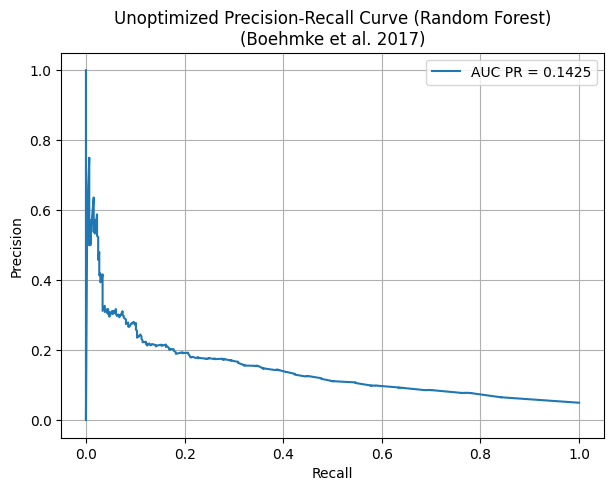

In [2]:
### Boehmke et al. 2017 RF (No Optimization)

# Fit
random_forest = RandomForestClassifier(random_state = 1337)

start_time = time.time()
random_forest.fit(X_train_scaled, y_train)
end_time = time.time()

# Predict
y_pred = random_forest.predict(X_test_scaled)

# Eval Statistics
f1_macro = f1_score(y_test, y_pred, average = 'macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1 Macro Score: {f1_macro}")
print(f"Balanced Accuracy: {balanced_acc}")
print("Classification Report:\n", report)

# Get predicted probabilities for the positive class
y_scores = random_forest.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize = (7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Unoptimized Precision-Recall Curve (Random Forest)\n(Boehmke et al. 2017)')
plt.legend()
plt.grid(True)
plt.savefig('figures/boehmke2017/unoptimized_rf_boehmke.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
### Boehmke et al. 2017 RF (Optimized)

# Define the parameter search space for BayesSearchCV
param_grid = [
    {
        'n_estimators': (100, 300, 500),
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': ['sqrt', 'log2', None],
        'max_leaf_nodes': (10, 50),
        'bootstrap': [True],
        'class_weight': [None, 'balanced'],
        'ccp_alpha': (0.0, 0.1, 'uniform'),
        'max_samples': (0.5, 0.75)
    },
    {
        'n_estimators': (100, 500),
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': ['sqrt', 'log2', None],
        'max_leaf_nodes': (10, 50),
        'bootstrap': [False],
        'class_weight': [None, 'balanced'],
        'ccp_alpha': (0.0, 0.1, 'uniform'),
        'max_samples': [None]
    }
]

bayes_search = BayesSearchCV(
    estimator = RandomForestClassifier(random_state = 1337),
    search_spaces = param_grid,
    n_iter = 128,
    cv = 10,
    n_jobs = -1,
    verbose = 0,
    scoring = 'f1',
    random_state = 1337
)

start_time = time.time()
bayes_search.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"BayesSearchCV took {end_time - start_time:.2f} seconds")
print("Best parameters found:", bayes_search.best_params_)

# Get the best model
best_model = bayes_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test_scaled)

# Eval Statistics
f1_macro = f1_score(y_test, y_pred, average = 'macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1 Macro Score: {f1_macro}")
print(f"Balanced Accuracy: {balanced_acc}")
print("Classification Report:\n", report)

# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize = (7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Optimized Precision-Recall Curve (Random Forest)\n(Boehmke et al. 2017)')
plt.legend()
plt.grid(True)
plt.savefig('figures/boehmke2017/optimized_rf_boehmke.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [9]:
### Preprocessing Boushey 2016

# Data
boushey_2016_full = pd.read_stata(r"data/boushey2016.dta")

# Covariates
covariates = ["policycongruent","gub_election","elect2", "hvd_4yr", "fedcrime",
                "leg_dem_per_2pty","dem_governor","insession","propneighpol",
                "citidist","squire_prof86","citi6008","crimespendpc","crimespendpcsq",
                "violentthousand","pctwhite","stateincpercap","logpop","counter","counter2","counter3"]
boushey_2016 = boushey_2016_full[["state", "styear", "dvadopt"] + covariates].dropna()

# Define X and y
X = boushey_2016[['state'] + covariates].copy()
X = pd.get_dummies(X, columns = ['state'], drop_first = True)  # drop_first avoids perfect multicollinearity
y = boushey_2016['dvadopt']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337, stratify = y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

F1 Macro Score: 0.5254405038330598
Balanced Accuracy: 0.5218960887522429
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3822
         1.0       0.33      0.05      0.09       289

    accuracy                           0.93      4111
   macro avg       0.63      0.52      0.53      4111
weighted avg       0.89      0.93      0.90      4111

Average Precision (AUC PR): 0.1974


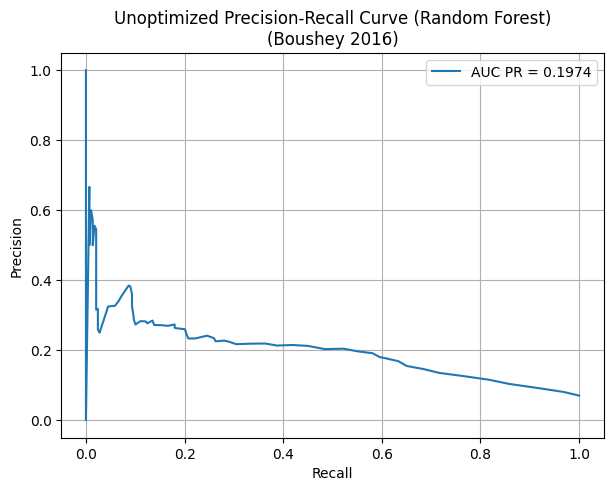

In [10]:
### Boushey 2016 RF (No Optimization)

# Fit
random_forest = RandomForestClassifier(random_state = 1337)

start_time = time.time()
random_forest.fit(X_train_scaled, y_train)
end_time = time.time()

# Predict
y_pred = random_forest.predict(X_test_scaled)

# Eval Statistics
f1_macro = f1_score(y_test, y_pred, average = 'macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1 Macro Score: {f1_macro}")
print(f"Balanced Accuracy: {balanced_acc}")
print("Classification Report:\n", report)

# Get predicted probabilities for the positive class
y_scores = random_forest.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize = (7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Unoptimized Precision-Recall Curve (Random Forest)\n(Boushey 2016)')
plt.legend()
plt.grid(True)
plt.savefig('figures/boushey2016/unoptimized_rf_boushey.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
### Boushey 2016 RF (Optimized)

# Define the parameter search space for BayesSearchCV
param_grid = [
    {
        'n_estimators': (100, 300, 500),
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': ['sqrt', 'log2', None],
        'max_leaf_nodes': (10, 50),
        'bootstrap': [True],
        'class_weight': [None, 'balanced'],
        'ccp_alpha': (0.0, 0.1, 'uniform'),
        'max_samples': (0.5, 0.75)
    },
    {
        'n_estimators': (100, 500),
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'max_features': ['sqrt', 'log2', None],
        'max_leaf_nodes': (10, 50),
        'bootstrap': [False],
        'class_weight': [None, 'balanced'],
        'ccp_alpha': (0.0, 0.1, 'uniform'),
        'max_samples': [None]
    }
]

bayes_search = BayesSearchCV(
    estimator = RandomForestClassifier(random_state = 1337),
    search_spaces = param_grid,
    n_iter = 128,
    cv = 10,
    n_jobs = -1,
    verbose = 0,
    scoring = 'f1',
    random_state = 1337
)

start_time = time.time()
bayes_search.fit(X_train_scaled, y_train)
end_time = time.time()
print(f"BayesSearchCV took {end_time - start_time:.2f} seconds")
print("Best parameters found:", bayes_search.best_params_)

# Get the best model
best_model = bayes_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test_scaled)

# Eval Statistics
f1_macro = f1_score(y_test, y_pred, average = 'macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"F1 Macro Score: {f1_macro}")
print(f"Balanced Accuracy: {balanced_acc}")
print("Classification Report:\n", report)

# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize = (7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Optimized Precision-Recall Curve (Random Forest)\n(Boushey 2016)')
plt.legend()
plt.grid(True)
plt.savefig('figures/boushey2016/optimized_rf_boushey.png', dpi = 300, bbox_inches = 'tight')
plt.show()